In [2]:
from env import Enviroment
from evolved_agent import EvolvedAgent
from actors import Agent, Wall, Landmark
from typing import List
import numpy as np
from copy import deepcopy
from math import degrees, atan2, pi
from utils import distance_from_wall, intersection, angle_from_vector, intersection_line_circle
import torch
from nn import NN
from parameters import *
import matplotlib.pyplot as plt
from numpy import ceil
import pygame
import math
import matplotlib.animation as animation

class EnvEvolution(Enviroment):
    def __init__(
        self,
        agent: EvolvedAgent,
        walls: List[Wall] = [],
        landmarks: List[Landmark] = [],
        height=800,
        width=800,
        instants=1000,
        w1=1,
        w2=1,
        w3=0.2,
        
    ):
        super().__init__(agent, walls, landmarks)
        self.height = height
        self.width = width
        self.map = np.zeros((self.width, self.height))
        self.collisions = 0
        self.movements = 0
        self.instants = instants
        self.W1 = w1
        self.W2 = w2
        self.W3 = w3
        self.distance = self.agent.max_distance * np.ones(self.instants)
        self.path = []
        self.map = np.zeros((self.width, self.height))
        self.w = []

    def reset(self, random=False):
        if random:
            self.agent.pos = np.array(
                [np.random.randint(0, self.width), np.random.randint(0, self.height)],
                dtype=np.float64,
            )
            self.agent.direction_vector = np.array(
                [np.random.randint(-1, 2), np.random.randint(-1, 2)], dtype=np.float64
            )
        else:
            self.agent.pos = np.array([self.width // 2, self.height // 2], dtype=np.float64)
        self.collisions = 0
        self.movements = 0
        self.map = np.zeros((self.width, self.height))
        self.distance = self.agent.max_distance * np.ones(self.instants)
        self.path = []

    def move_agent(self, dt=1):
        try:
            distances = np.array([data[1][0] for data in  self.get_sensor_data(self.agent.n_sensors, self.agent.max_distance)], dtype=np.float32)
            vl, vr = self.agent.controller.forward(torch.tensor(distances, dtype=torch.float))
        except Exception as e:
            print(e)
            vl, vr = 0, 0
        v, w = (vl + vr) / 2, (vr - vl) / (self.agent.size * 2)
        #print(f"v: {v}, w: {w}", "vl", vl, "vr", vr)   
        if distances[0] > 30:
            w, v = 0, v * 2
            v *= 2
        if distances[0] < self.agent.size + 5:
            w, v = 0, -v
        if np.isnan(v) or np.isnan(w):
            exit()
        dx,dy, dtheta = 0,0, w * dt
        if w == 0:
            dx = v * dt * np.cos(self.agent.direction)
            dy = v * dt * np.sin(self.agent.direction)
        else:
            R = v / w
            dx = R * (np.sin(self.agent.direction + dtheta) - np.sin(self.agent.direction))
            dy = -R * (np.cos(self.agent.direction + dtheta) - np.cos(self.agent.direction))

        
        dx, dy = round(dx), round(dy)
        x, y = self.agent.pos.copy()
        new_x, new_y = x + dx, y + dy
        size = self.agent.size

        for wall in self.walls:
            x1, y1, x2, y2 = wall.start[0], wall.start[1], wall.end[0], wall.end[1]
            if x1 > x2:
                x1, x2 = x2, x1
            if y1 > y2:
                y1, y2 = y2, y1
            
            if x == x1:
                if dy > 0 and new_y - size <= y1:
                    self.collisions += 1
                    self.agent.apply_vector(np.array([0, y1 - y - size - 1]))
                    dy, new_y, y = 0, y1 - size - 1, y1 - size - 1
                elif dy < 0 and new_y + size >= y1:
                    self.collisions += 1
                    self.agent.apply_vector(np.array([0, y1 - y + size + 1]))
                    dy, new_y, y = 0, y1 + size + 1, y1 + size + 1
            if y == y1:
                if dx > 0 and new_x - size <= x1:
                    self.collisions += 1
                    self.agent.apply_vector(np.array([x1 - x - size - 1, 0]))
                    dx, new_x, x = 0, x1 - size - 1, x1 - size - 1
                elif dx < 0 and new_x + size >= x1:
                    self.collisions += 1
                    self.agent.apply_vector(np.array([x1 - x + size + 1, 0]))
                    dx, new_x, x = 0, x1 + size + 1, x1 + size + 1
            
            if new_x <= 0 or new_x >= self.width or new_y <= 0 or new_y >= self.height:
                return
            # Vertical wall
            if x1 == x2 and x != new_x:
                if dx > 0 and  x + size < x1 and new_x > x1 - size and y + size >= y1 and y - size <= y2:
                    self.collisions += 1    
                    self.agent.apply_vector(np.array([x1 - x - size - 1, 0]))
                    dx, new_x, x = 0, x1 - size - 1, x1 - size - 1
                    
                elif dx < 0 and x - size >= x1 and new_x <= x1 + size and y + size >= y1 and y - size <= y2:
                    self.collisions += 1
                    self.agent.apply_vector(np.array([x1 - x + size + 1, 0]))
                    dx, new_x, x = 0, x1 + size + 1, x1 + size + 1
            
            # Horizontal wall
            elif y1 == y2:
                if dy > 0 and y + size <= y1 and new_y >= y1 - size and x + size >= x1 and x - size <= x2:
                    self.collisions += 1
                    self.agent.apply_vector(np.array([0, y1 - y - size - 1]))
                    dy, new_y, y = 0, y1 - size - 1, y1 - size - 1
                elif dy < 0 and y - size >= y1 and new_y <= y1 + size and x + size >= x1 and x - size <= x2:
                    self.collisions += 1
                    self.agent.apply_vector(np.array([0, y1 - y + size + 1]))
                    dy, new_y, y = 0, y1 + size + 1, y1 + size + 1
                
            
   
        move_vector = np.array([dx, dy])
            
        #print(f"dx: {dx}, dy: {dy}, dtheta: {dtheta}")
            
        self.agent.apply_vector(move_vector)
        # Set visited positions to 1 within -10 to +10 range around agent's position
        x_start = max(0, int(self.agent.pos[0]) - 10)
        x_end = min(self.map.shape[0], int(self.agent.pos[0]) + 10 + 1)
        y_start = max(0, int(self.agent.pos[1]) - 10)
        y_end = min(self.map.shape[1], int(self.agent.pos[1]) + 10 + 1)

        # Efficiently set the range using numpy slicing
        self.map[x_start:x_end, y_start:y_end] = 1

        # Append the new position to the path
        self.path.append((self.agent.pos[0], self.agent.pos[1]))

        # Rotate the agent
        self.agent.rotate(dtheta)

    def fitness_score(self) -> float:
        #mean_angular_velocity = np.mean(np.abs(self.w))
        #print(f"Mean Angular Velocity: {mean_angular_velocity}")
        if self.collisions == 0:
            return self.explored_terrain #- mean_angular_velocity
        return self.explored_terrain #+ 1 / self.collisions - mean_angular_velocity
    @property
    def explored_terrain(self) -> float:
        return np.sum(self.map) / (self.width * self.height)

    def visualize_movement(self):
        if self.path == []:
            return

        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(self.map.T, origin='lower', cmap='gray_r')
        ax.scatter(self.agent.pos[0], self.agent.pos[1], color='green', s=self.agent.size * 6.28, label='Agent')
        for wall in self.walls:
            ax.plot([wall.start[0], wall.end[0]], [wall.start[1], wall.end[1]], 'b-', linewidth=2)
        
        # Plot the path
        path = np.array(self.path)
        ax.plot(path[:, 0], path[:, 1], 'r-', label='Path')
        
        ax.set_title('Agent Movement and Explored Terrain')
        ax.set_xlabel('Width')
        ax.set_ylabel('Height')
        ax.legend()
        plt.show()

pygame 2.5.2 (SDL 2.28.3, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


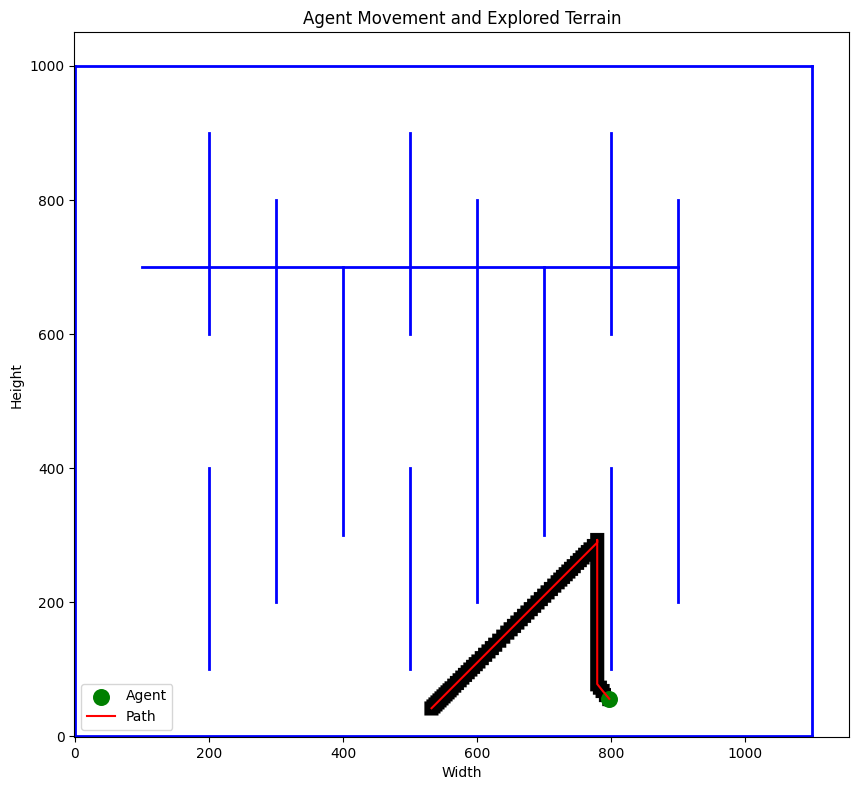

final pos [797.  56.] initial pos [530.  40.]  collisions 40 explored terrain 0.0228125 fitness 0.0228125


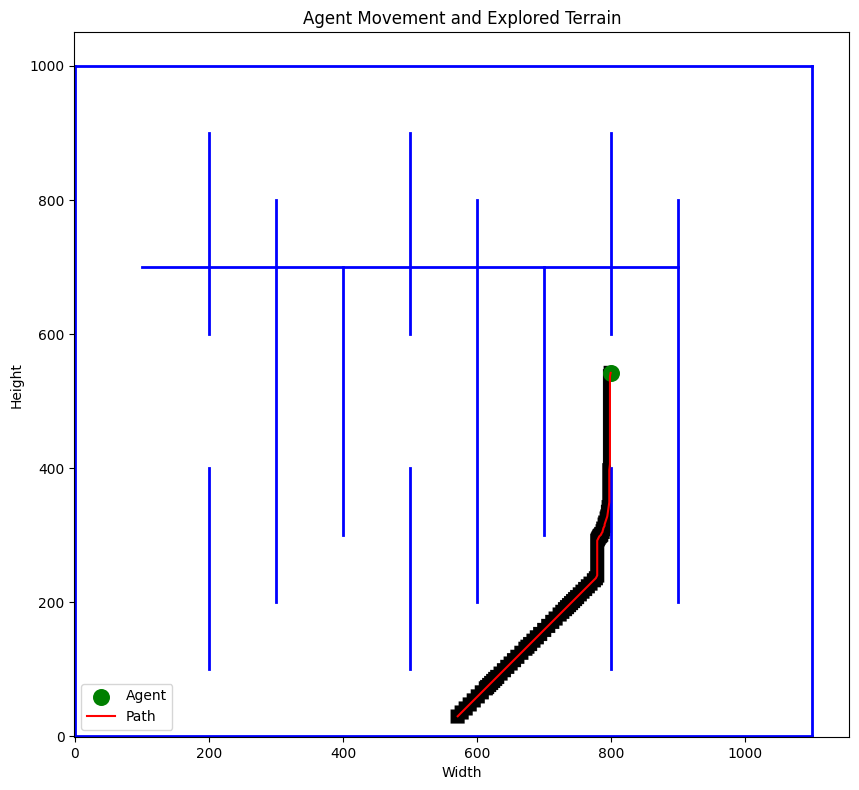

final pos [799. 542.] initial pos [564.  23.]  collisions 18 explored terrain 0.0200890625 fitness 0.0200890625


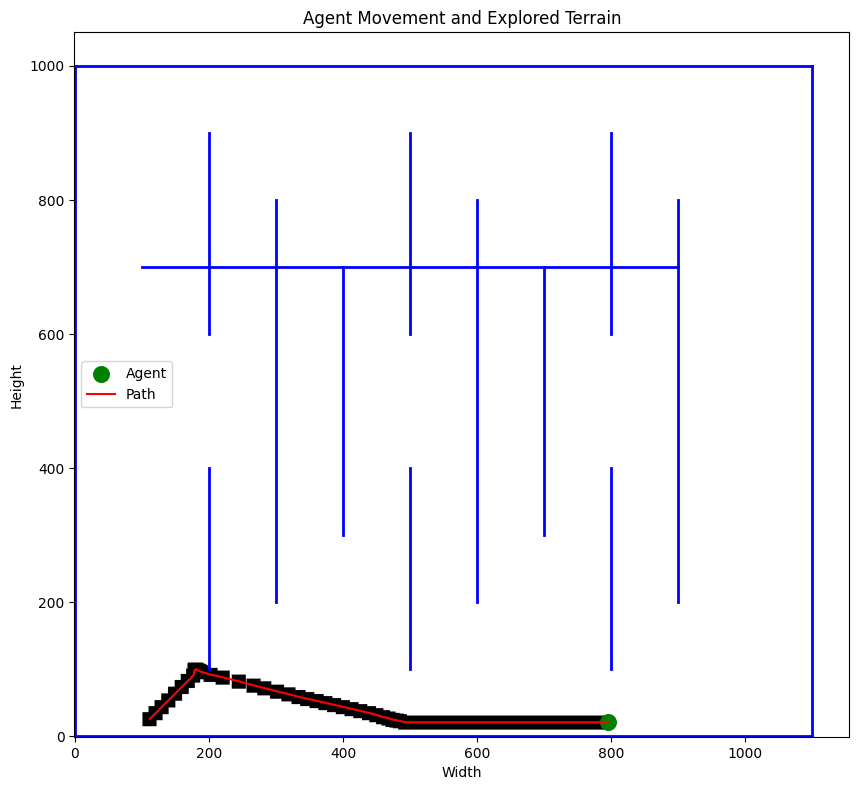

final pos [795.  21.] initial pos [104.  18.]  collisions 44 explored terrain 0.0250078125 fitness 0.0250078125


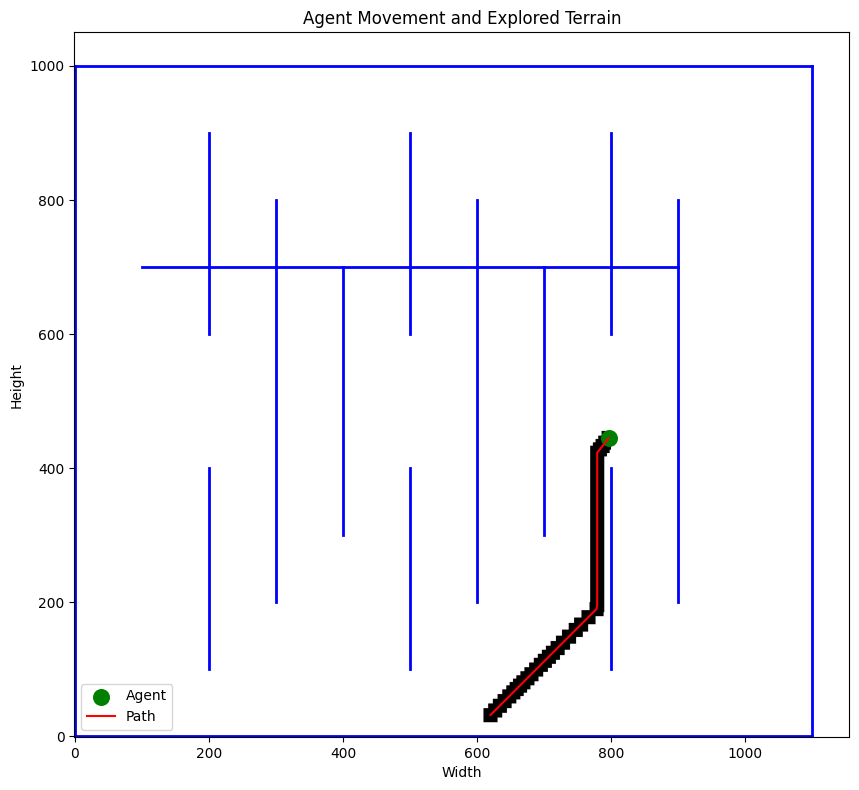

final pos [796. 445.] initial pos [612.  24.]  collisions 26 explored terrain 0.01771875 fitness 0.01771875


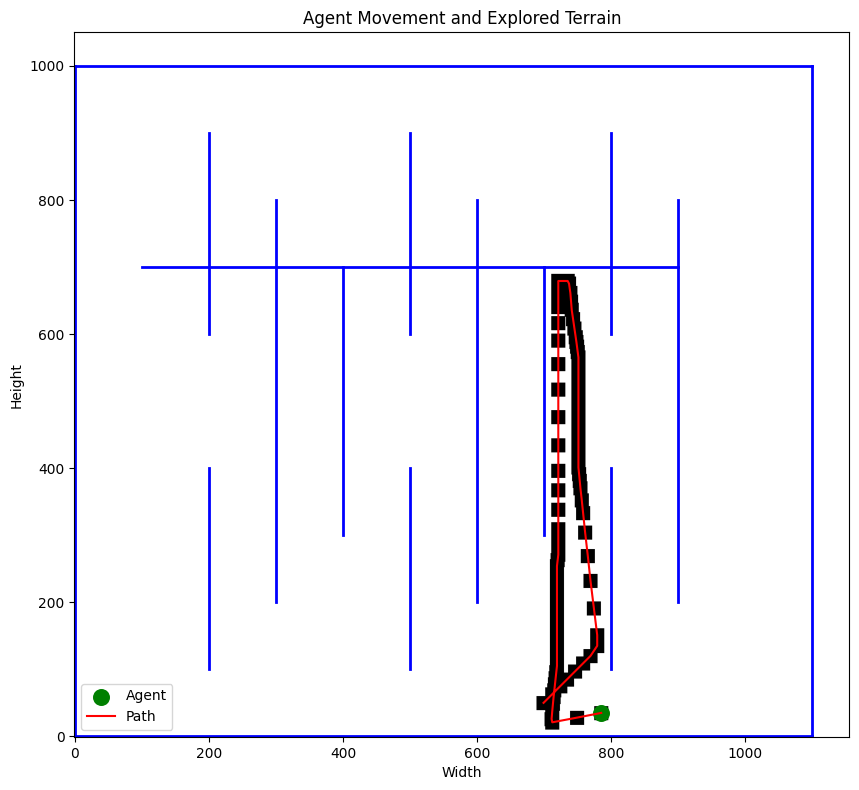

final pos [785.  35.] initial pos [683.  34.]  collisions 21 explored terrain 0.0385578125 fitness 0.0385578125


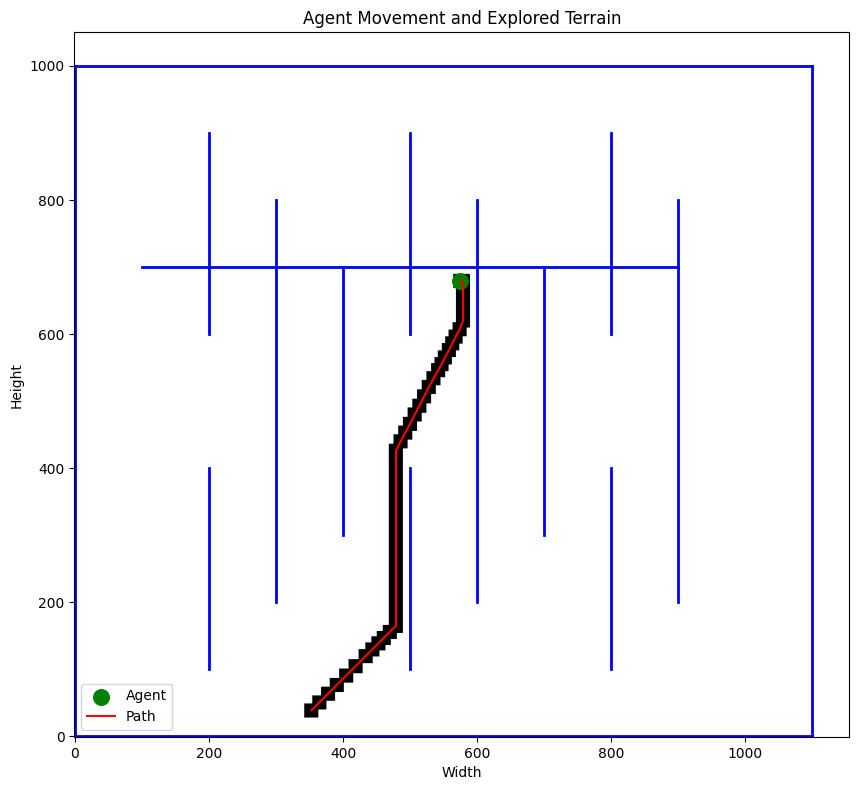

final pos [575. 679.] initial pos [341.  27.]  collisions 28 explored terrain 0.02495625 fitness 0.02495625


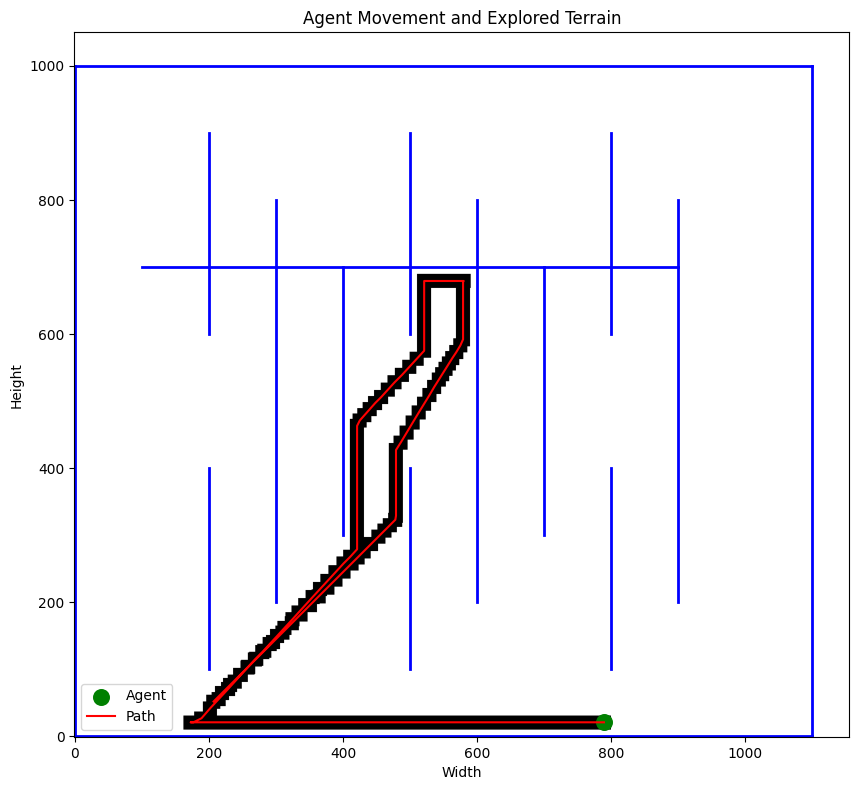

final pos [789.  21.] initial pos [195.  40.]  collisions 144 explored terrain 0.066759375 fitness 0.066759375


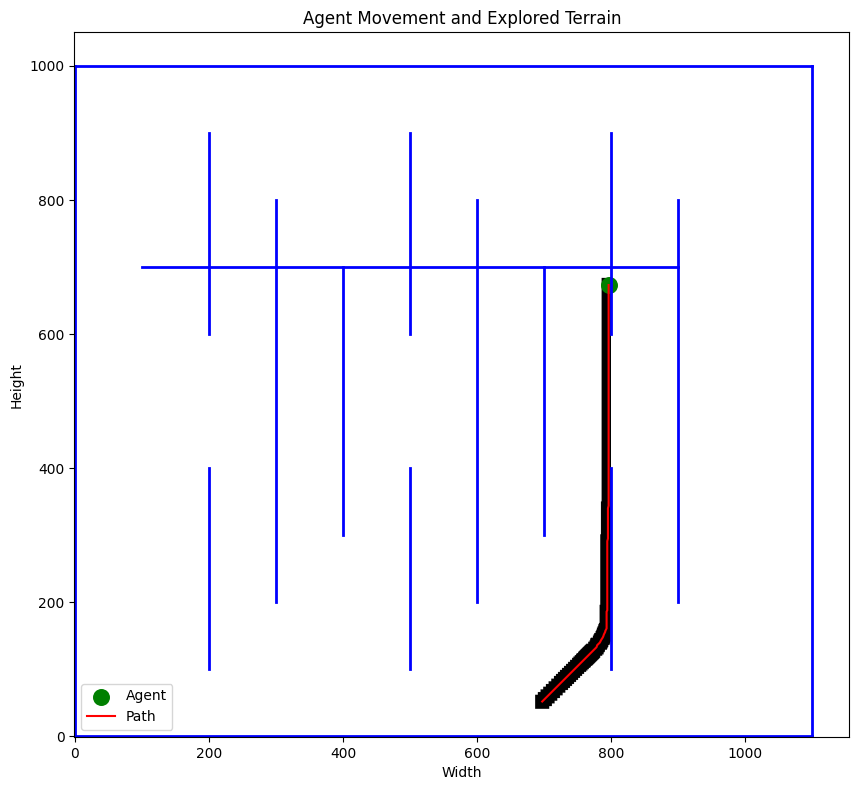

final pos [796. 673.] initial pos [694.  49.]  collisions 1 explored terrain 0.0185609375 fitness 0.0185609375


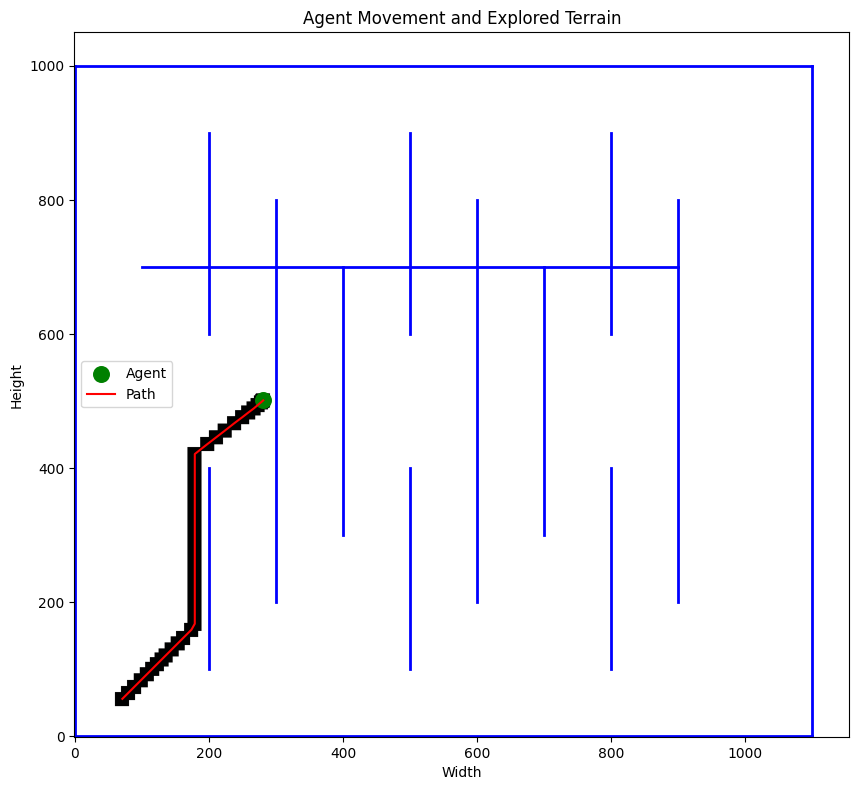

final pos [281. 501.] initial pos [61. 46.]  collisions 51 explored terrain 0.0191671875 fitness 0.0191671875


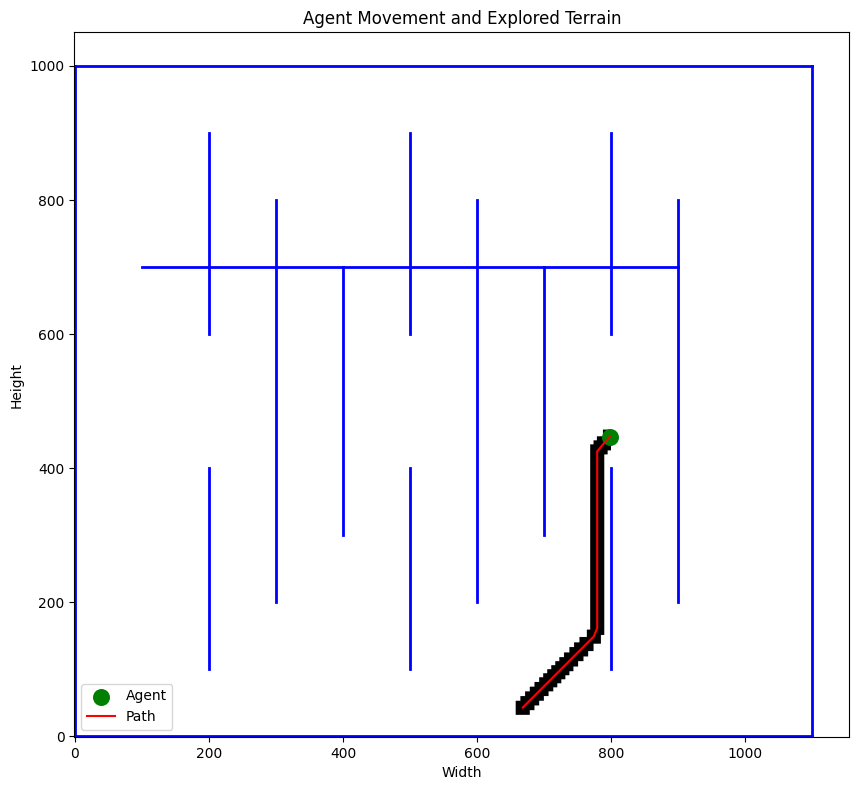

final pos [798. 447.] initial pos [661.  36.]  collisions 24 explored terrain 0.0163734375 fitness 0.0163734375


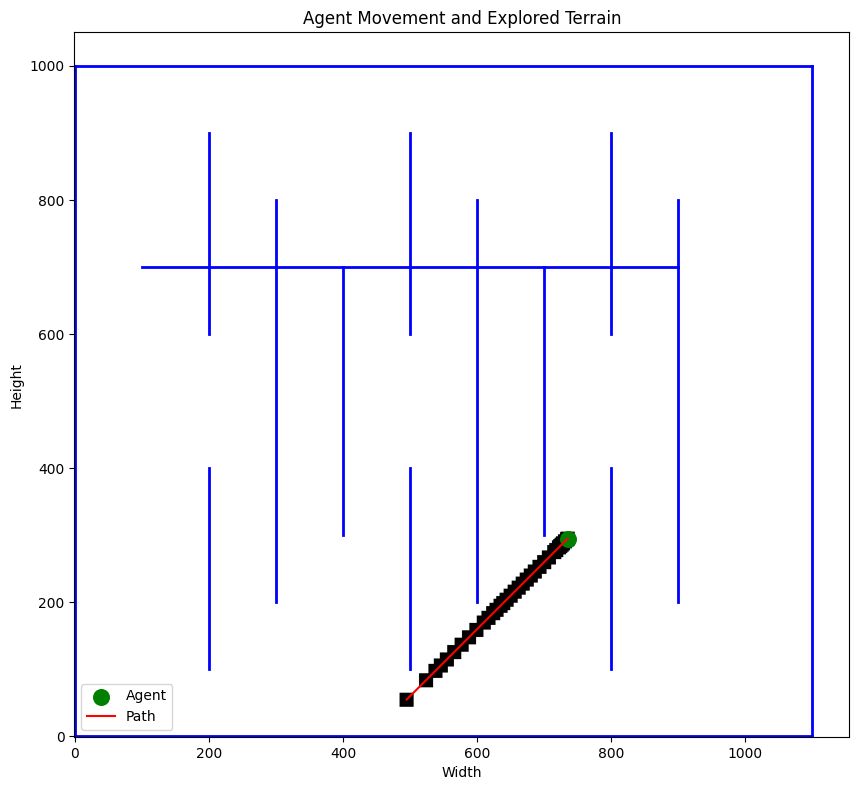

final pos [735. 295.] initial pos [466.  26.]  collisions 0 explored terrain 0.0126234375 fitness 0.0126234375


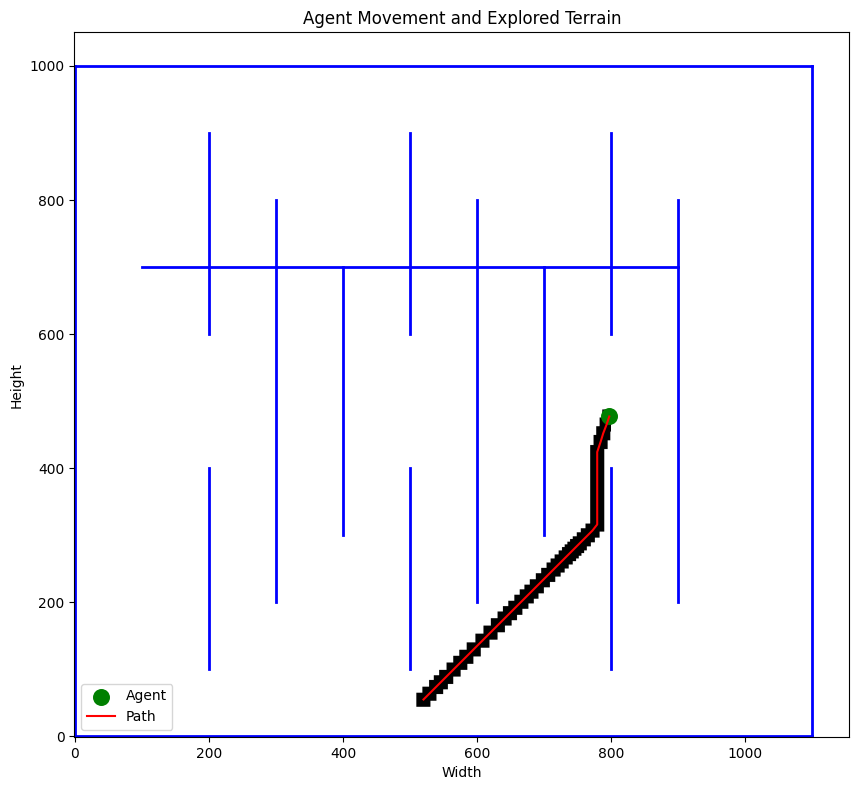

final pos [797. 477.] initial pos [505.  40.]  collisions 9 explored terrain 0.0194328125 fitness 0.0194328125


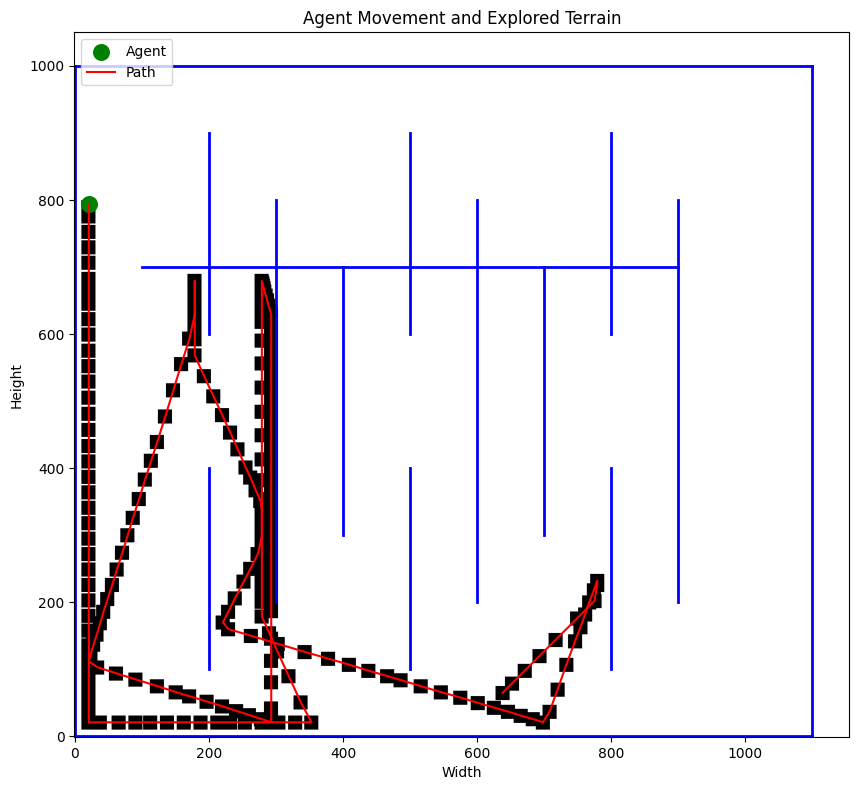

final pos [ 21. 794.] initial pos [619.  46.]  collisions 106 explored terrain 0.1150328125 fitness 0.1150328125


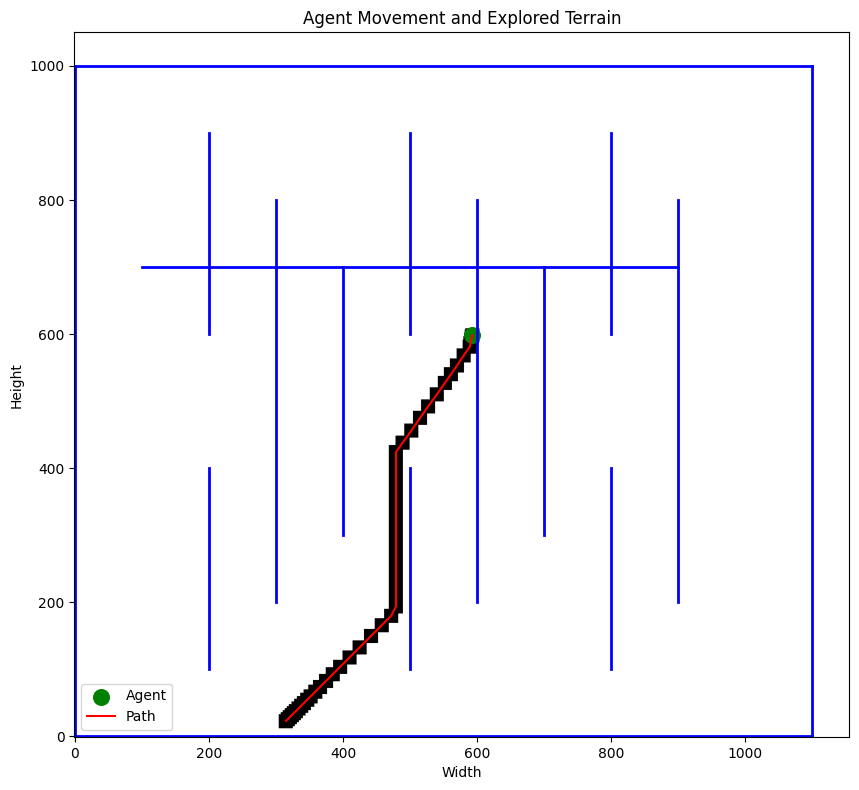

final pos [593. 598.] initial pos [312.  20.]  collisions 19 explored terrain 0.023078125 fitness 0.023078125


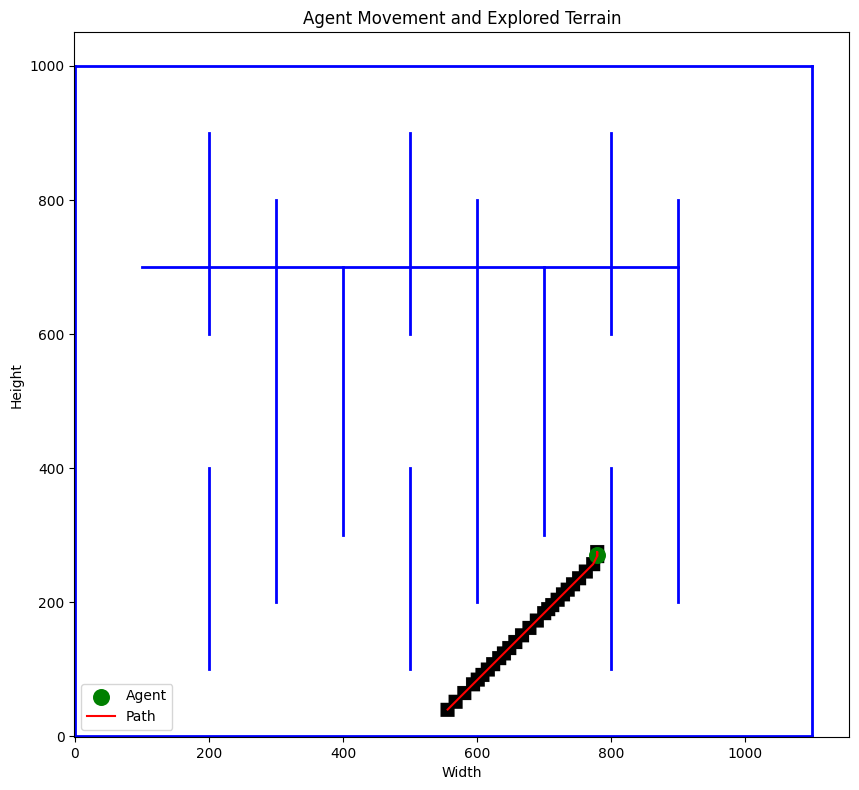

final pos [779. 270.] initial pos [546.  30.]  collisions 4 explored terrain 0.012384375 fitness 0.012384375


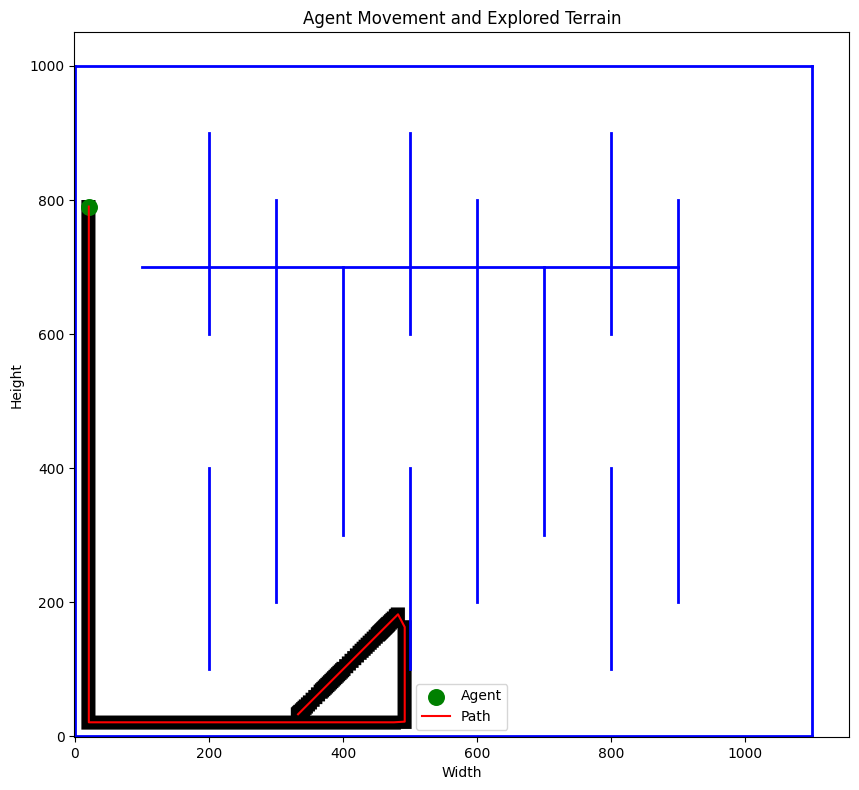

final pos [ 21. 790.] initial pos [332.  32.]  collisions 100 explored terrain 0.055371875 fitness 0.055371875


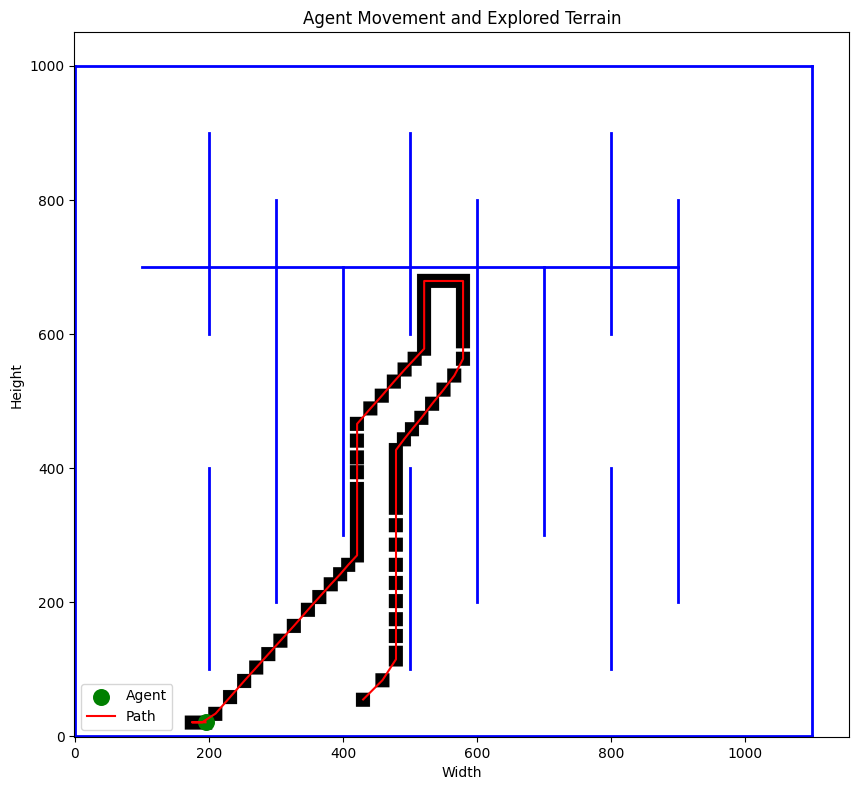

final pos [195.  21.] initial pos [406.  31.]  collisions 64 explored terrain 0.043453125 fitness 0.043453125


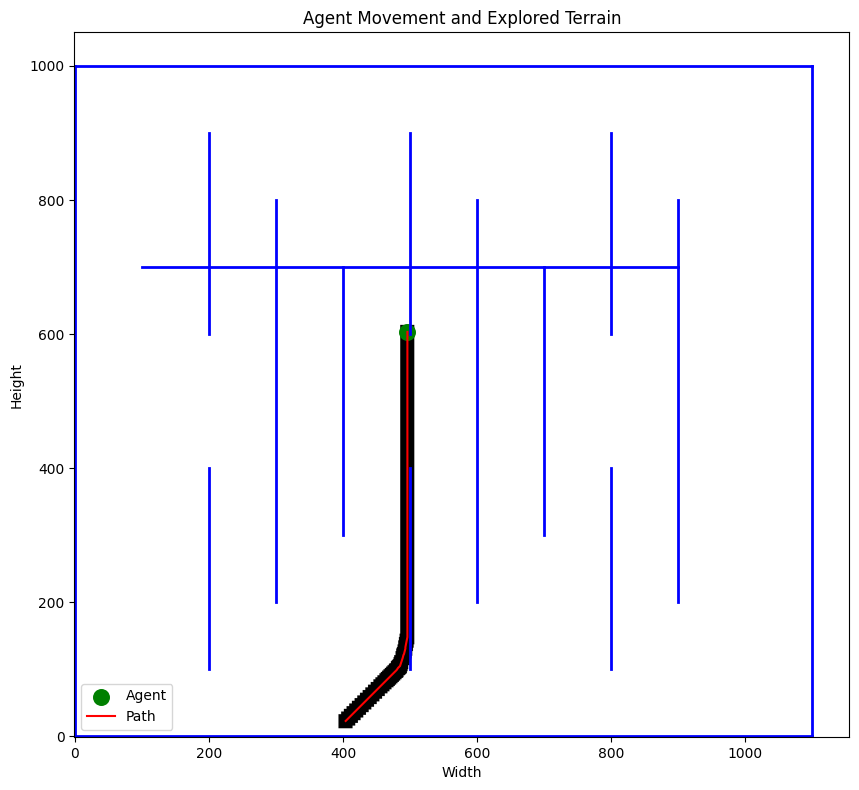

final pos [496. 603.] initial pos [399.  18.]  collisions 0 explored terrain 0.0222390625 fitness 0.0222390625


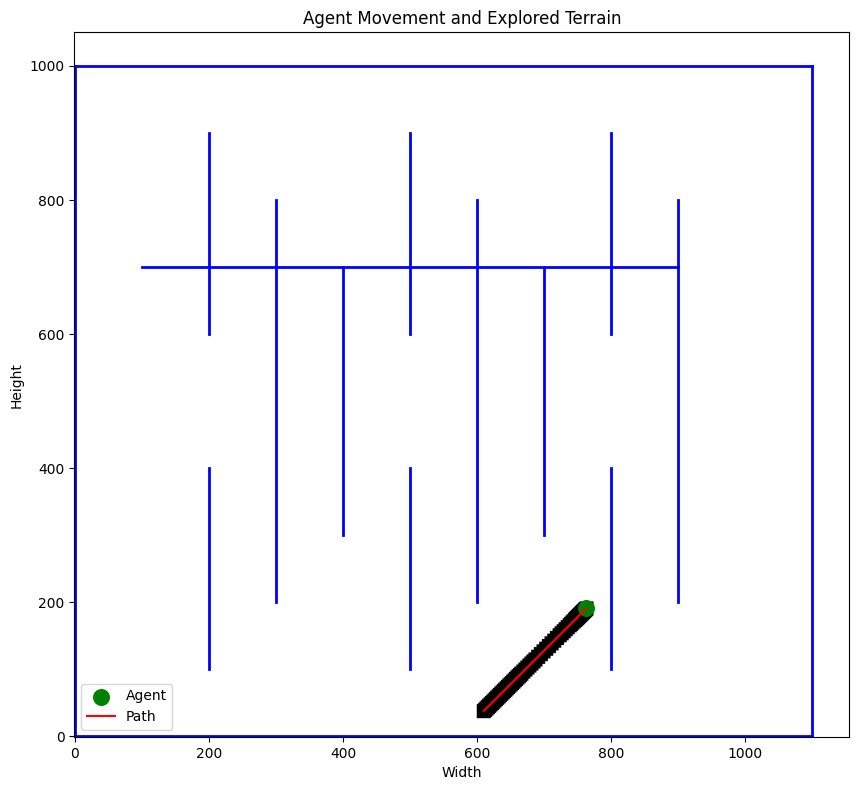

final pos [763. 191.] initial pos [608.  36.]  collisions 0 explored terrain 0.010109375 fitness 0.010109375


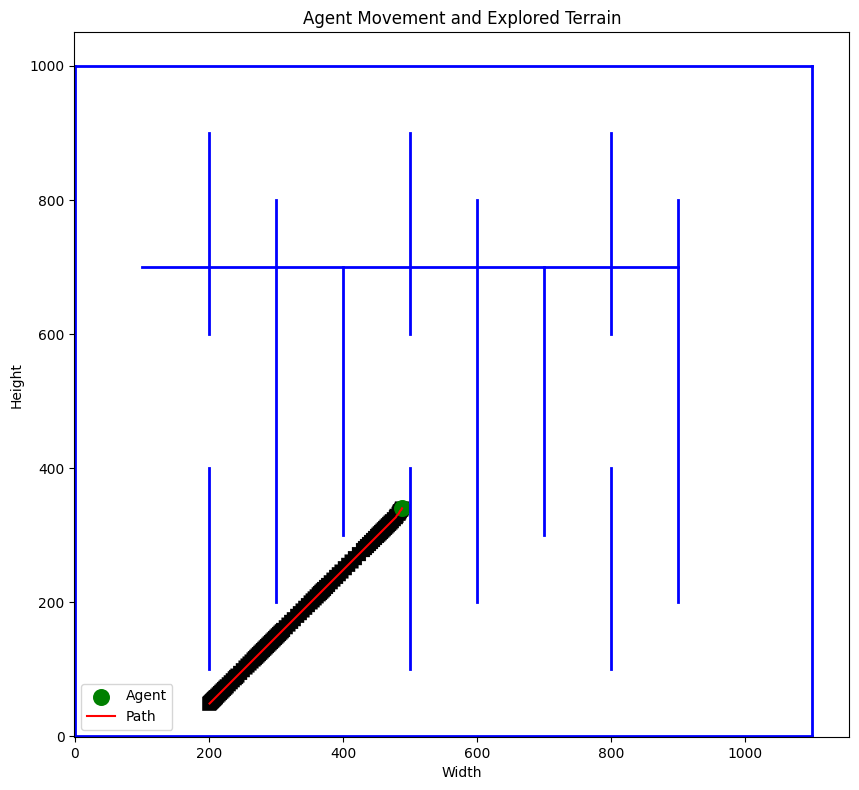

final pos [488. 340.] initial pos [199.  47.]  collisions 0 explored terrain 0.01825625 fitness 0.01825625


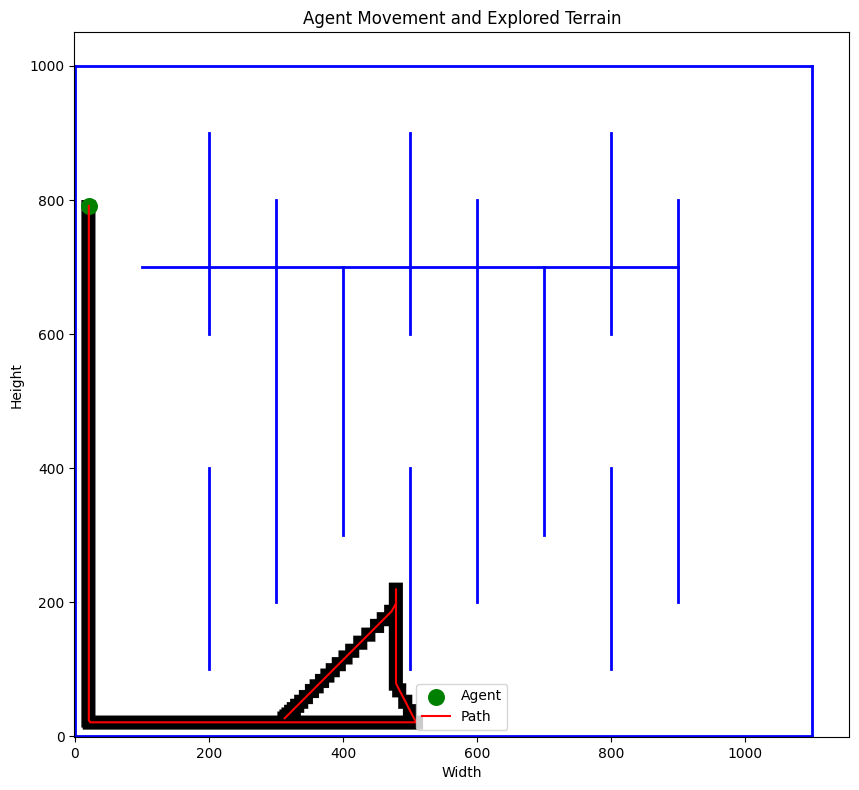

final pos [ 21. 791.] initial pos [310.  24.]  collisions 173 explored terrain 0.056340625 fitness 0.056340625


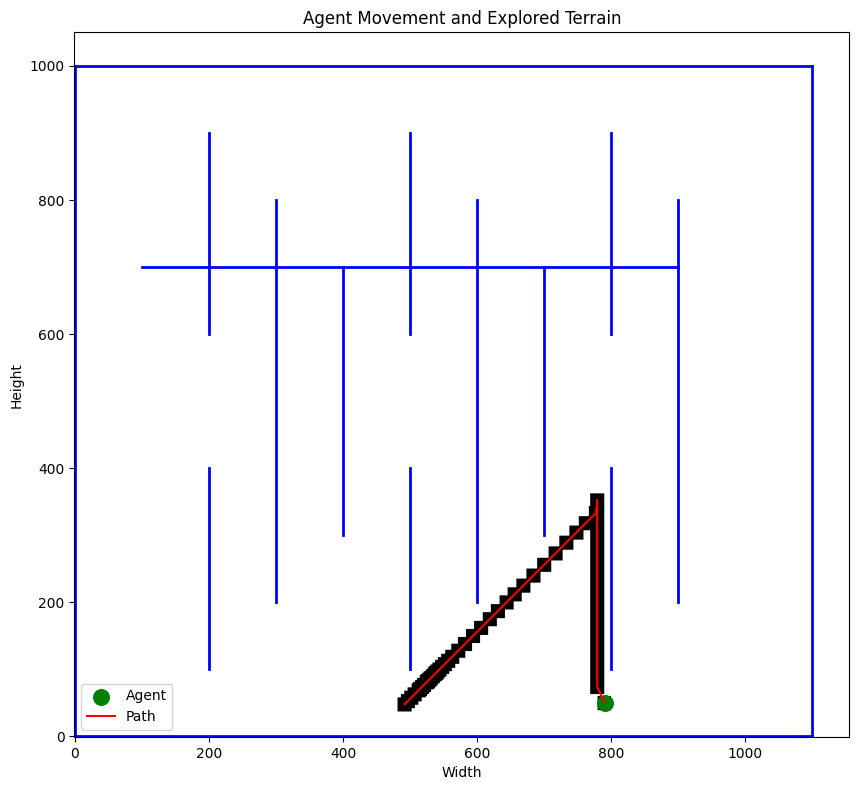

final pos [790.  50.] initial pos [487.  43.]  collisions 25 explored terrain 0.02410625 fitness 0.02410625


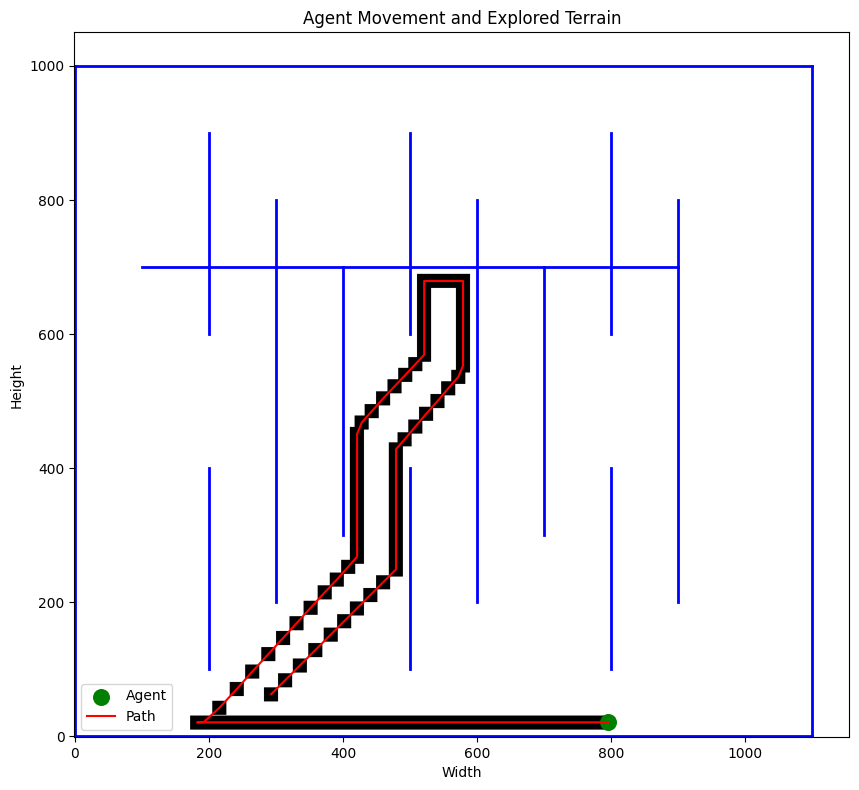

final pos [795.  21.] initial pos [275.  45.]  collisions 110 explored terrain 0.0648265625 fitness 0.0648265625


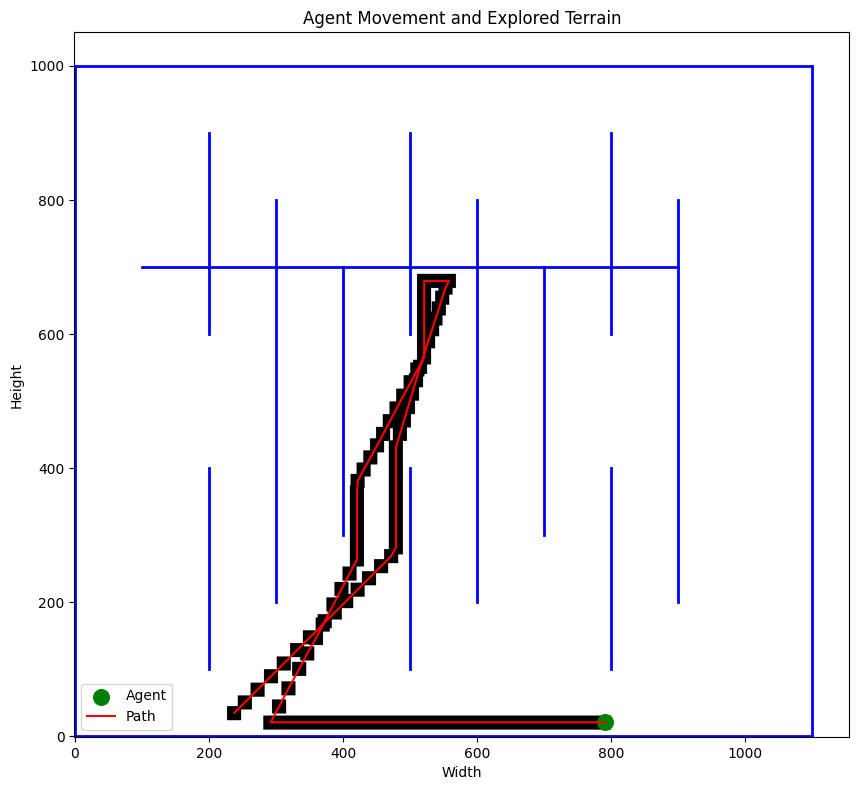

final pos [791.  21.] initial pos [225.  22.]  collisions 70 explored terrain 0.05725 fitness 0.05725


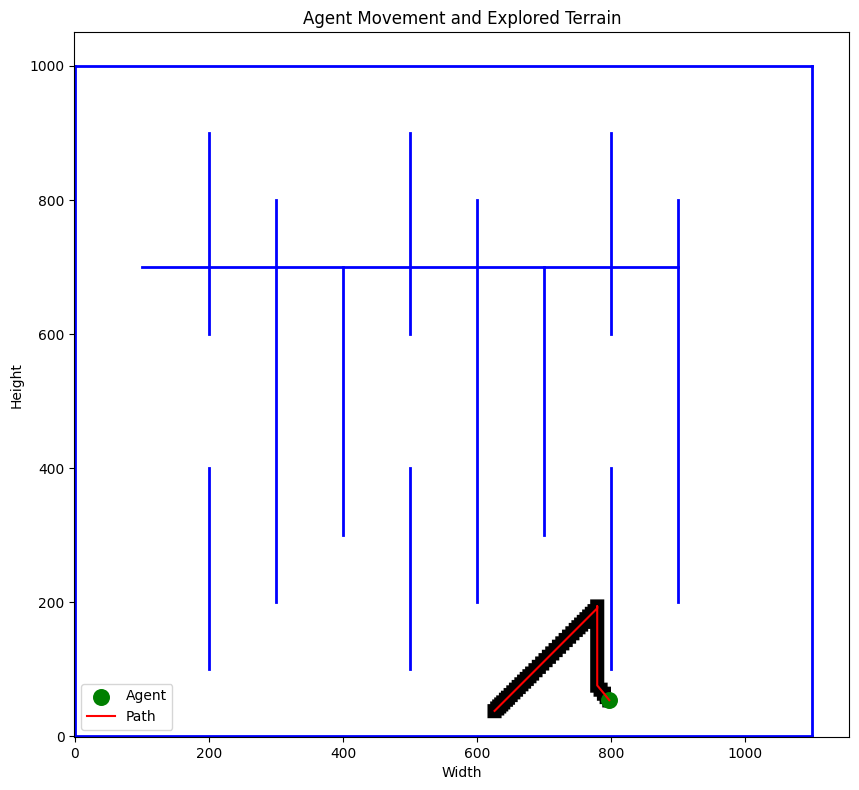

final pos [797.  54.] initial pos [622.  34.]  collisions 30 explored terrain 0.01414375 fitness 0.01414375


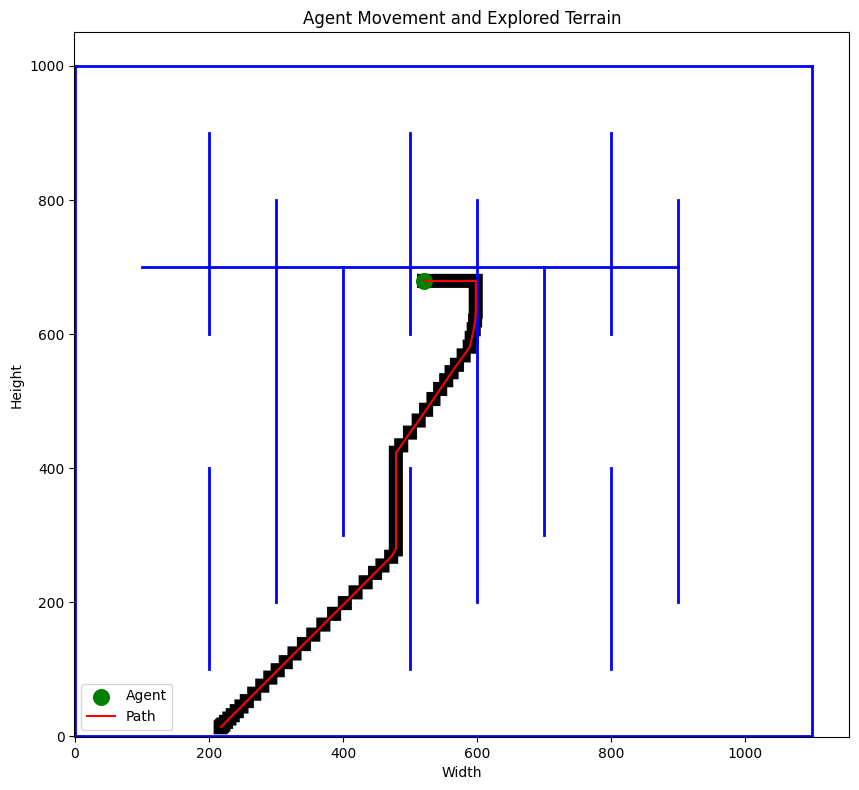

final pos [521. 679.] initial pos [216.  12.]  collisions 44 explored terrain 0.029715625 fitness 0.029715625


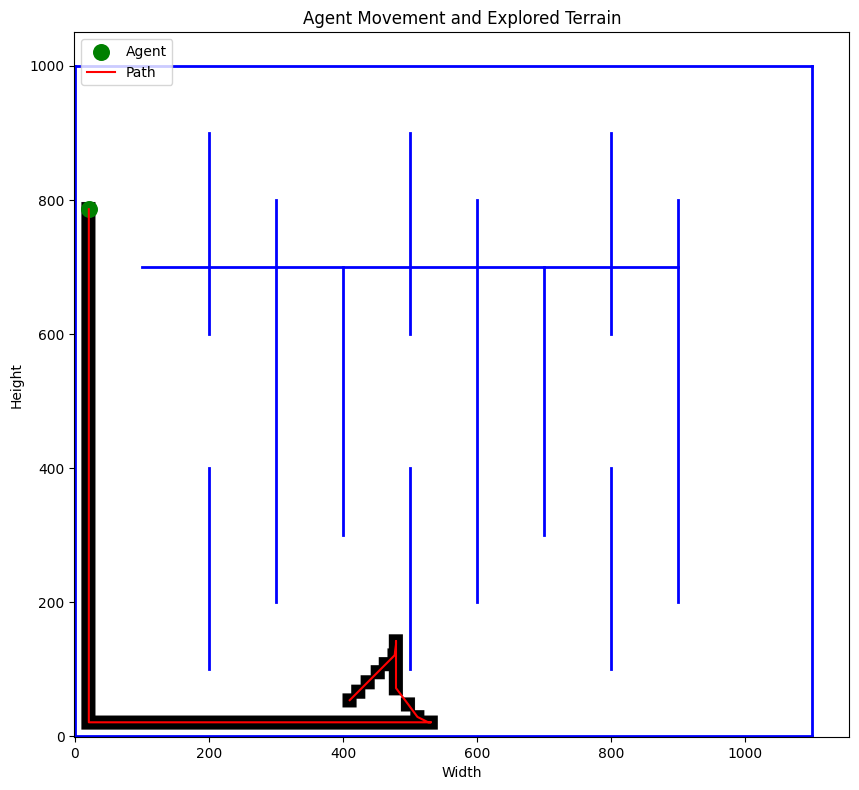

final pos [ 21. 786.] initial pos [397.  41.]  collisions 81 explored terrain 0.0493703125 fitness 0.0493703125


KeyboardInterrupt: 

In [3]:
for simulation in range(10000):    
    x,y = float(np.random.randint(10, 1000)), float(np.random.randint(10, 50))
    env = EnvEvolution(
        EvolvedAgent(x=x, y=y, controller=NN(), n_sensors=12, max_distance=200,size=20),
        instants=10000,
        w1=1,
        w2=1,
        w3=0.2,
    )
    env.agent.rotate(pi/4)
    #env.agent.controller.load_state_dict(torch.load("./saves/best_last_agent.pth"))
    env.load_walls(WALLS_TXT)
    initial_pos = env.agent.pos.copy()
    for step in range(15000):
        if step == 100 and env.explored_terrain < 0.01:
            break
        env.move_agent()
        
        
    if env.explored_terrain < 0.01:
        continue
    env.visualize_movement()
    print("final pos", env.agent.pos, "initial pos", initial_pos, " collisions", env.collisions, "explored terrain", env.explored_terrain, "fitness", env.fitness_score())
 